# Agentic Predictive Maintenance for Insured Assets
---
**Objective:** Develop an agentic predictive maintenance solution using time-series sensor data.

**Core Components:**
* **Data:** Time-series sensor data, policy data, and maintenance logs/manuals.
* **Model:** Time-aware model selection (forecasting/classification) and hyperparameter tuning.
* **Agent:** An AI agent combining deterministic checks, RAG (retrieval from manuals), and LLM reasoning to provide explainable maintenance recommendations.

## Batch Processing: Full Pipeline for All Datasets (FD001-FD004)

This cell executes the complete **Data Engineering Pipeline** for all four CMAPSS subsets.
It orchestrates the modules we created earlier (`data_ingest`, `time_cleaning`, `feature_tools`, `scaling`).

**Pipeline Logic per Dataset:**
1.  **Ingest:** Loads raw text files, computes RUL, saves intermediate CSVs.
2.  **Clean:** Aligns cycles, fills missing values (imputation), and caps outliers.
3.  **Feature Engineering:** Generates temporal features (rolling mean/std, lag, trends) and anomaly indicators on the *physical* (unscaled) values.
4.  **Scaling:**
    * **FD001 & FD003:** Uses `Global Standardization` (single scaler).
    * **FD002 & FD004:** Uses `Conditional Standardization` (clusters data by operating conditions first, then scales per cluster) to handle complex regimes.
5.  **Save:** exports the final, model-ready data to `data/processed/CMAPSS/`.

In [1]:
import pandas as pd
from pathlib import Path
import time
import warnings

# --- 1. Suppress Warnings ---
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

# 1. Import Your Modules
from agentic_pm import data_ingest, time_cleaning, feature_tools, scaling

# --- CONFIG ---
SUBSETS = ["FD001", "FD002", "FD003", "FD004"]

RAW_DIR = Path("data/raw/CMAPSS")
INTERMEDIATE_DIR = Path("data/intermediate/CMAPSS")
PROCESSED_DIR = Path("data/processed/CMAPSS")
SCALER_DIR = Path("artifacts/scalers")

# Create directories if they don't exist
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)
SCALER_DIR.mkdir(parents=True, exist_ok=True)


def run_full_pipeline(subset_name):
    """
    Runs the End-to-End Pipeline for a single subset:
    Ingest -> Clean -> Feature Eng -> Scale -> Save
    """
    start_time = time.time()
    print(f"\n{'='*40}")
    print(f"🚀 Processing Subset: {subset_name}")
    print(f"{'='*40}")

    # ---------------------------------------------------------
    # STEP 1: INGEST (Load Raw & Compute RUL)
    # ---------------------------------------------------------
    print(f"1️⃣ Ingesting data...")
    data_ingest.process_subset(subset_name, raw_base=RAW_DIR, out_base=INTERMEDIATE_DIR)
    
    # Load intermediate raw data
    train_df = pd.read_csv(INTERMEDIATE_DIR / subset_name / f"train_{subset_name}_raw.csv")
    test_df  = pd.read_csv(INTERMEDIATE_DIR / subset_name / f"test_{subset_name}_raw.csv")

    # ---------------------------------------------------------
    # STEP 2: CLEANING
    # ---------------------------------------------------------
    print(f"2️⃣ Cleaning data (Align, Impute, Cap Outliers)...")
    train_df = time_cleaning.align_cycles(train_df)
    train_df = time_cleaning.impute_missing(train_df)
    train_df = time_cleaning.cap_outliers(train_df)

    test_df = time_cleaning.align_cycles(test_df)
    test_df = time_cleaning.impute_missing(test_df)
    test_df = time_cleaning.cap_outliers(test_df)

    # ---------------------------------------------------------
    # STEP 3: FEATURE ENGINEERING (On Physical Values)
    # ---------------------------------------------------------
    print(f"3️⃣ Engineering Features...")
    # Train
    train_df = feature_tools.create_temporal_features(train_df)
    train_df = feature_tools.create_anomaly_indicators(train_df)
    train_df = feature_tools.compute_health_index(train_df)
    
    # Test
    test_df = feature_tools.create_temporal_features(test_df)
    test_df = feature_tools.create_anomaly_indicators(test_df)
    test_df = feature_tools.compute_health_index(test_df)

    # ---------------------------------------------------------
    # STEP 4: SCALING (Prepare for ML Model)
    # ---------------------------------------------------------
    print(f"4️⃣ Scaling features...")
    
    # Identify feature columns (exclude metadata)
    # We exclude 'unit', 'cycle', 'RUL', 'gap_flag' and the raw 'op_settings' if we want
    # Usually we KEEP op_settings as features, but we scale them.
    cols_to_exclude = ['unit', 'cycle', 'RUL', 'gap_flag', 'anom_score'] 
    # Note: 'anom_score' is 0-1 flag based, usually doesn't need scaling, but can be scaled.
    # Let's include everything else.
    feature_cols = [c for c in train_df.columns if c not in cols_to_exclude]

    # Logic: FD001/FD003 -> Global Scaling
    #        FD002/FD004 -> Conditional Scaling (due to multiple operating conditions)
    if subset_name in ["FD001", "FD003"]:
        print(f"   -> Using Global Standardization")
        train_scaled, test_scaled, _ = scaling.global_standardize(
            train_df, test_df, feature_cols, subset_name=subset_name
        )
    else:
        print(f"   -> Using Conditional Standardization (Clustering)")
        op_cols = ["op_setting_1", "op_setting_2", "op_setting_3"]
        train_scaled, test_scaled, _, _ = scaling.conditional_standardize(
            train_df, test_df, feature_cols, op_cols, subset_name=subset_name
        )

    # ---------------------------------------------------------
    # STEP 5: SAVE FINAL DATA
    # ---------------------------------------------------------
    print(f"5️⃣ Saving final processed data...")
    final_train_path = PROCESSED_DIR / f"train_{subset_name}_final.csv"
    final_test_path = PROCESSED_DIR / f"test_{subset_name}_final.csv"
    
    train_scaled.to_csv(final_train_path, index=False)
    test_scaled.to_csv(final_test_path, index=False)
    
    elapsed = time.time() - start_time
    print(f"✅ Done with {subset_name} in {elapsed:.2f} seconds.")
    print(f"   Saved shape: Train {train_scaled.shape}, Test {test_scaled.shape}")


# ==========================================
# MAIN EXECUTION LOOP
# ==========================================
print("📢 Starting Batch Processing for All Subsets...")

for subset in SUBSETS:
    try:
        run_full_pipeline(subset)
    except Exception as e:
        print(f"\n❌ FAILED on {subset}: {e}")
        # Uncomment 'raise' if you want to stop the whole notebook on error
        # raise e 

print("\n🎉🎉 ALL DATASETS PROCESSED SUCCESSFULLY! 🎉🎉")

📢 Starting Batch Processing for All Subsets...

🚀 Processing Subset: FD001
1️⃣ Ingesting data...
[data_ingest] Processing FD001 ...
[data_ingest] Saved: data\intermediate\CMAPSS\FD001\train_FD001_raw.csv, data\intermediate\CMAPSS\FD001\test_FD001_raw.csv
2️⃣ Cleaning data (Align, Impute, Cap Outliers)...
3️⃣ Engineering Features...
4️⃣ Scaling features...
   -> Using Global Standardization
[scaling] Saved global scaler: artifacts\scalers\FD001_global_scaler.pkl
5️⃣ Saving final processed data...
✅ Done with FD001 in 796.00 seconds.
   Saved shape: Train (20631, 428), Test (13096, 428)

🚀 Processing Subset: FD002
1️⃣ Ingesting data...
[data_ingest] Processing FD002 ...
[data_ingest] Saved: data\intermediate\CMAPSS\FD002\train_FD002_raw.csv, data\intermediate\CMAPSS\FD002\test_FD002_raw.csv
2️⃣ Cleaning data (Align, Impute, Cap Outliers)...
3️⃣ Engineering Features...
4️⃣ Scaling features...
   -> Using Conditional Standardization (Clustering)


C:\myProjects\Agentic-Predictive-Maintenance\agentic_pm\scaling.py:79: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.04280095 -0.04280095 -0.04280095 ... -0.04280095 -0.04280095
 -0.04280095]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  train_t.loc[mask_tr, feature_cols] = scaler.transform(train_t.loc[mask_tr, feature_cols].values)
C:\myProjects\Agentic-Predictive-Maintenance\agentic_pm\scaling.py:79: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.02310017 -0.02310017 -0.02310017 ... -0.02310017 -0.02310017
 -0.02310017]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  train_t.loc[mask_tr, feature_cols] = scaler.transform(train_t.loc[mask_tr, feature_cols].values)
C:\myProjects\Agentic-Predictive-Maintenance\agentic_pm\scaling.py:7

[scaling] Saved 6 cluster scalers and unit->cluster map for FD002
5️⃣ Saving final processed data...
✅ Done with FD002 in 2404.56 seconds.
   Saved shape: Train (53759, 429), Test (33991, 429)

🚀 Processing Subset: FD003
1️⃣ Ingesting data...
[data_ingest] Processing FD003 ...
[data_ingest] Saved: data\intermediate\CMAPSS\FD003\train_FD003_raw.csv, data\intermediate\CMAPSS\FD003\test_FD003_raw.csv
2️⃣ Cleaning data (Align, Impute, Cap Outliers)...
3️⃣ Engineering Features...
4️⃣ Scaling features...
   -> Using Global Standardization
[scaling] Saved global scaler: artifacts\scalers\FD003_global_scaler.pkl
5️⃣ Saving final processed data...
✅ Done with FD003 in 1117.04 seconds.
   Saved shape: Train (24720, 428), Test (16596, 428)

🚀 Processing Subset: FD004
1️⃣ Ingesting data...
[data_ingest] Processing FD004 ...
[data_ingest] Saved: data\intermediate\CMAPSS\FD004\train_FD004_raw.csv, data\intermediate\CMAPSS\FD004\test_FD004_raw.csv
2️⃣ Cleaning data (Align, Impute, Cap Outliers)...
3️

C:\myProjects\Agentic-Predictive-Maintenance\agentic_pm\scaling.py:79: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.01223247 -0.01223247 -0.01223247 ... -0.01223247 -0.01223247
 -0.01223247]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  train_t.loc[mask_tr, feature_cols] = scaler.transform(train_t.loc[mask_tr, feature_cols].values)
C:\myProjects\Agentic-Predictive-Maintenance\agentic_pm\scaling.py:79: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.01223247 -0.01223247 -0.01223247 ... -0.01223247 -0.01223247
 -0.01223247]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  train_t.loc[mask_tr, feature_cols] = scaler.transform(train_t.loc[mask_tr, feature_cols].values)
C:\myProjects\Agentic-Predictive-Maintenance\agentic_pm\scaling.py:7

[scaling] Saved 6 cluster scalers and unit->cluster map for FD004
5️⃣ Saving final processed data...
✅ Done with FD004 in 2634.24 seconds.
   Saved shape: Train (61249, 429), Test (41214, 429)

🎉🎉 ALL DATASETS PROCESSED SUCCESSFULLY! 🎉🎉


### Labeling & Problem Framing

#### 1. Task Definition
For this project, we explicitly define the prediction task as:

- **(B) Remaining Useful Life (RUL) Regression**  
  The model predicts the number of cycles remaining before the asset reaches end-of-life (failure threshold).  
  Alternative tasks (A: time-to-failure regression, C: binary/multi-class maintenance classification) were considered but not selected for this iteration.

---

#### 2. Assumptions
- Each *cycle* in the CMAPSS dataset represents a consistent time step (uniform sampling frequency).  
- The degradation process is monotonic toward failure within each unit’s operational trajectory.  
- Units in the training set run until failure; units in the test set are truncated before failure.  
- Sensor measurements are assumed to be correctly calibrated and synchronized.  
- No maintenance occurs during each unit’s recorded run unless explicitly annotated.

---

#### 3. Sampling Frequency
- **Sampling interval:** One record per engine per cycle (i.e., *per-cycle sampling*).  

---

#### 4. Label Generation Rules

##### **Training Data**
- Each unit runs until failure; therefore:
  
  \[
  RUL_{train}(unit, t) = \text{max\_cycle(unit)} - t
  \]

##### **Test Data**
- Test trajectories end before failure. Ground-truth final RUL values are provided separately.
  
  \[
  RUL_{test}(unit, t) = RUL_{given}(unit) + (\text{final\_cycle(unit)} - t)
  \]

##### **Optional Enhancements**
- Clip large RUL values (e.g., max 130 cycles) to stabilize model training.  
- Apply transformations (e.g., `log1p(RUL)`) when using models sensitive to scale.

---

#### 5. Example Asset Timelines (Annotated)

Below we illustrate two example trajectories:

1. **Training unit (full run):**
   - Starts healthy, degrades over time, ends in a failure event.  
   - RUL decreases linearly with respect to cycle index until reaching zero at the final cycle.

2. **Test unit (truncated run):**
   - Sequence ends before failure.  
   - Final RUL label is assigned by combining the provided RUL file with the time remaining from the last observed cycle.

These annotated timelines help verify label correctness, confirm continuity, and validate assumptions about degradation behavior.


# 📝 Project Status Checkpoint: Data Pipeline & Feature Engineering

At this stage, we have successfully implemented the **Data Engineering** and **Tool Definition** layers of our Agentic Predictive Maintenance system. Instead of raw processing within the notebook, we have modularized our code into the `agentic_pm` package for reproducibility and scalability.

### Summary of Accomplishments:

#### 1. Data Ingestion & Cleaning (Layer 1)
We processed the raw CMAPSS datasets (FD001-FD004) through a rigorous cleaning pipeline:
* **Ingestion:** Loaded raw text files and computed the **Remaining Useful Life (RUL)** target.
* **Alignment:** Used `align_cycles` to create a continuous time index for each asset, handling missing timestamps.
* **Imputation:** Filled sensor gaps using linear interpolation (`impute_missing`).
* **Noise Reduction:** Applied a rolling Z-score filter (`cap_outliers`) to smooth extreme sensor spikes while retaining the signal.

#### 2. Feature Engineering (Layer 2)
We generated advanced features on the *cleaned physical values* (before normalization) to capture temporal dynamics:
* **Temporal Features:** Rolling Means & Standard Deviations (window sizes 5, 15, 60), Exponential Moving Averages (EMA), and Lag features.
* **Anomaly Indicators:** Computed Z-scores and change-point detection flags to highlight abnormal sensor behavior.
* **Health Index:** Created a composite score combining weighted sensor values to represent overall asset health.

#### 3. Agent Tools (Layer 3)
We implemented deterministic tools that our AI Agent will call later:
* **`diagnostic_checker`:** A rule-based tool that checks specific physical thresholds (e.g., *Temperature > 800°C*) to flag immediate risks.
* **`maintenance_simulator`:** A "what-if" tool to simulate the impact of preventive maintenance on failure probability.

#### 4. Scaling & Normalization (Layer 4)
To prepare the data for Machine Learning models, we applied dataset-specific scaling:
* **Global Standardization:** Applied to **FD001 & FD003** (single operating condition).
* **Conditional Standardization:** Applied to **FD002 & FD004** (multiple operating conditions), using KMeans clustering to normalize data within specific operating regimes.

---
**✅ Current State:** Cleaned, feature-engineered, and normalized datasets are saved in `data/processed/CMAPSS/`.
**👉 Next Step:** We will now proceed to **Step 3: Model Selection**, where we will train and evaluate models (XGBoost, etc.) using time-aware validation strategies.

## 3. Model Selection, Hyperparameter Tuning & Evaluation
### 3.1 Import & Config

In [36]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

from agentic_pm.modeling import model_selection as ms

DATA_DIR = Path("data/processed/CMAPSS")
SUBSET = "FD001"
train_path = DATA_DIR / f"train_{SUBSET}_final.csv"
test_path  = DATA_DIR / f"test_{SUBSET}_final.csv"

print("train_path:", train_path.exists(), train_path)
print("test_path:", test_path.exists(), test_path)


train_path: True data\processed\CMAPSS\train_FD001_final.csv
test_path: True data\processed\CMAPSS\test_FD001_final.csv


### 3.2 Load processed data, quick sanity checks

In [37]:
train_df = pd.read_csv(train_path)
test_df  = pd.read_csv(test_path)

print("Shapes: train", train_df.shape, "test", test_df.shape)
display(train_df.head())

# Quick check that RUL is present and non-negative
print("RUL min/max train:", train_df['RUL'].min(), train_df['RUL'].max())


Shapes: train (20631, 428) test (13096, 428)


,cycle,unit,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_13_norm_unit,sensor_14_norm_unit,sensor_15_norm_unit,sensor_16_norm_unit,sensor_17_norm_unit,sensor_18_norm_unit,sensor_19_norm_unit,sensor_20_norm_unit,sensor_21_norm_unit,health_index
0,1,1,-0.315980,-1.372953,0.0,0.0,-1.721725,-0.134255,-0.925936,-5.329071e-15,...,-1.278164,1.997798,-0.380157,0.0,-0.833752,0.0,0.0,1.354811,1.317629,-0.534520
1,2,1,0.872722,-1.031720,0.0,0.0,-1.061780,0.211528,-0.643726,-5.329071e-15,...,-0.636957,1.072544,0.018526,0.0,-0.833752,0.0,0.0,0.991643,1.360548,-0.438211
2,3,1,-1.961874,1.015677,0.0,0.0,-0.661813,-0.413166,-0.525953,-5.329071e-15,...,-1.149922,1.298342,-0.435259,0.0,-2.053313,0.0,0.0,0.689003,0.619718,-0.618248
3,4,1,0.324090,-0.008022,0.0,0.0,-0.661813,-1.261314,-0.784831,-5.329071e-15,...,-0.508715,1.376204,-2.042955,0.0,-0.833752,0.0,0.0,0.265307,0.896829,-0.765705
4,5,1,-0.864611,-0.690488,0.0,0.0,-0.621816,-1.251528,-0.301518,-5.329071e-15,...,-1.021681,1.372310,-0.059266,0.0,-0.223972,0.0,0.0,0.386363,1.181405,-0.317219


RUL min/max train: 0 361


### 3.3 Visual Check — RUL Distribution

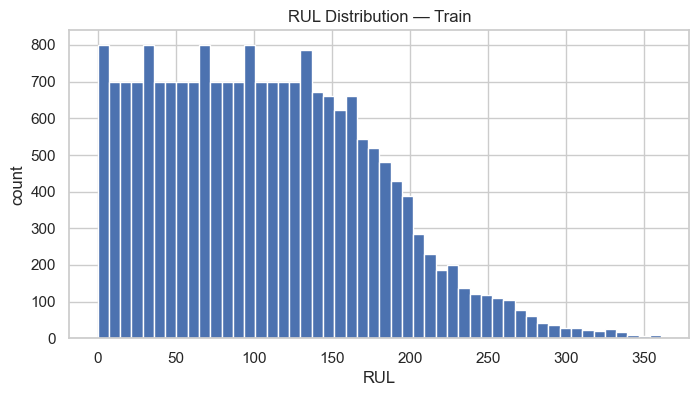

In [38]:
plt.figure(figsize=(8,4))
train_df["RUL"].hist(bins=50)
plt.title("RUL Distribution — Train")
plt.xlabel("RUL")
plt.ylabel("count")
plt.show()


### 3.4 Fix and run correct baselines (no leakage)

In [41]:
# Persistence baseline (shifted)
y_test = test_df['RUL'].values
y_pred_persist = ms.baseline_persistence_shift(test_df)   # corrected baseline
metrics_persist = ms.regression_metrics(y_test, y_pred_persist)
print("Persistence baseline (shifted) metrics:", metrics_persist)

# Moving average baseline: fit on train, predict on test (no leakage)
y_pred_ma = ms.baseline_ma_linear_map(train_df, test_df, sensor_col='sensor_1', window=10)
metrics_ma = ms.regression_metrics(y_test, y_pred_ma)
print("Moving-average baseline metrics:", metrics_ma)


Persistence baseline (shifted) metrics: {'MAE': 0.9923640806353085, 'RMSE': 0.9961747239492219, 'R2': 0.9997147057731792}
Moving-average baseline metrics: {'MAE': 54.127533447851036, 'RMSE': 67.79375906542671, 'R2': -0.3212998275171681}


### 3.5 Feature selection (reduce dimensions to avoid overfit)

In [42]:
# Select candidate features (drop metadata)
exclude = {'unit','cycle','RUL','gap_flag'}
all_feat = [c for c in train_df.columns if c not in exclude]
print("Total feature cols available:", len(all_feat))

# Simple variance-based filter: keep top-k highest-variance features + keep domain sensors and health_index
k = 80
var = train_df[all_feat].var().sort_values(ascending=False)
topk = list(var.index[:k])
# Ensure some domain features present
domain = [c for c in ['health_index','anom_score','op_setting_1','op_setting_2','op_setting_3'] if c in train_df.columns]
feature_cols = sorted(set(topk + domain))
print("Selected feature count:", len(feature_cols))


Total feature cols available: 425
Selected feature count: 85


### 3.6 Build X/y and time-aware per-unit holdout split

In [43]:
X = train_df[feature_cols].values
y = train_df['RUL'].values

# Per-unit holdout: last 30% cycles per unit for validation (no leakage)
train_idx, val_idx = ms.per_unit_holdout(train_df, holdout_frac=0.3)
print("train rows:", len(train_idx), "val rows:", len(val_idx))


2025-11-18 18:07:07,575 INFO Per-unit holdout: train rows=14398 val rows=6233 (holdout_frac=0.30)


train rows: 14398 val rows: 6233


### 3.7 Scale features (fit on train only)

In [44]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = X[train_idx]
X_val = X[val_idx]
X_train_s = scaler.fit_transform(X_train)
X_val_s = scaler.transform(X_val)


### 3.8 Train RandomForest (baseline strong) and evaluate

In [45]:
rf = ms.fit_random_forest(X_train_s, y[train_idx], params={"n_estimators":200, "max_depth":12, "min_samples_leaf":2})
y_val_pred_rf = rf.predict(X_val_s)
metrics_rf = ms.regression_metrics(y[val_idx], y_val_pred_rf)
print("RF metrics:", metrics_rf)
print("Precision@100 (rf):", ms.precision_at_k_rul(y[val_idx], y_val_pred_rf, k=100))
print("Early-warning@7 (rf):", ms.early_warning_rate(train_df.iloc[val_idx], y[val_idx], y_val_pred_rf, lead=7))


RF metrics: {'MAE': 26.9856491098807, 'RMSE': 30.965902531665254, 'R2': -1.2246320499591055}
Precision@100 (rf): 0.04
Early-warning@7 (rf): 0.0


### 3.8 Train LightGBM (simple params) and evaluate

In [56]:
# Use lightgbm if installed; else skip
try:
    lgb_model, _ = ms.fit_lightgbm(X_train_s, y[train_idx], X_val_s, y[val_idx],
                                   params={"objective":"regression","metric":"mae","learning_rate":0.05,"num_leaves":48,"verbosity":-1},
                                   num_boost_round=1000, early_stopping_rounds=50)
    y_val_pred_lgb = lgb_model.predict(X_val_s)
    metrics_lgb = ms.regression_metrics(y[val_idx], y_val_pred_lgb)
    print("LightGBM metrics:", metrics_lgb)
    print("Precision@100 (lgb):", ms.precision_at_k_rul(y[val_idx], y_val_pred_lgb, k=100))
    print("Early-warning@7 (lgb):", ms.early_warning_rate(train_df.iloc[val_idx], y[val_idx], y_val_pred_lgb, lead=7))
except Exception as e:
    print("LightGBM not available or failed:", e)


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[710]	val's l1: 18.0903
LightGBM metrics: {'MAE': 18.090268980715283, 'RMSE': 21.495357423431514, 'R2': -0.07196362008842083}
Precision@100 (lgb): 0.07
Early-warning@7 (lgb): 0.0


### 3.9 Plot sample unit true vs predicted (LightGBM if available, else RF)

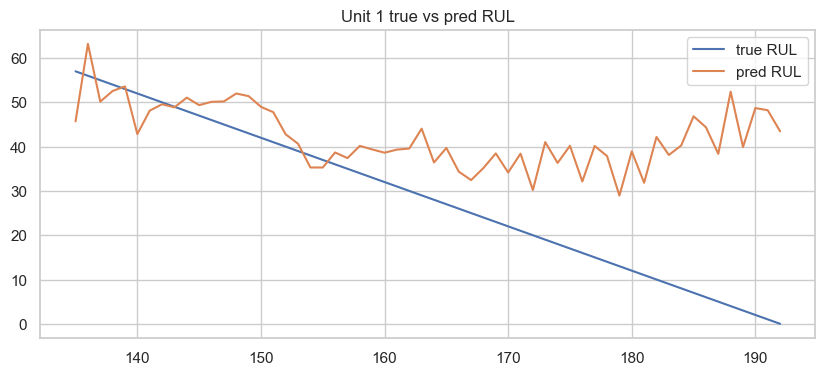

In [57]:
unit_sample = train_df.iloc[val_idx]['unit'].unique()[0]
unit_rows = train_df[(train_df.unit == unit_sample) & (train_df.index.isin(val_idx))]
Xu = scaler.transform(unit_rows[feature_cols].values)
y_pred_unit = (lgb_model.predict(Xu) if 'lgb_model' in globals() else rf.predict(Xu))
plt.figure(figsize=(10,4))
plt.plot(unit_rows.cycle.values, unit_rows.RUL.values, label='true RUL')
plt.plot(unit_rows.cycle.values, y_pred_unit, label='pred RUL')
plt.title(f"Unit {unit_sample} true vs pred RUL")
plt.legend(); plt.show()


### 3.10 Optuna Hyperparameter Tuning

In [59]:
import optuna

# Run only if Optuna installed and you want tuning time
try:
    study = ms.tune_lightgbm_optuna(np.vstack([X_train_s, X_val_s]), np.concatenate([y[train_idx], y[val_idx]]), train_df.iloc[np.concatenate([train_idx, val_idx])], n_trials=20)
    print("Best Optuna params:", study.best_params)
except Exception as e:
    print("Optuna tuning skipped:", e)
    

[I 2025-11-18 18:22:38,825] A new study created in memory with name: no-name-0de2c130-fda4-4916-aff3-b8df0c984408
2025-11-18 18:22:38,852 INFO Created 3 time-aware folds


Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[482]	val's l1: 53.7217
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[500]	val's l1: 61.0683
Training until validation scores don't improve for 30 rounds


[I 2025-11-18 18:23:06,431] Trial 0 finished with value: 62.560889265040714 and parameters: {'num_leaves': 78, 'learning_rate': 0.0011079837677329255, 'feature_fraction': 0.8455862555351941, 'bagging_fraction': 0.9738440308993981, 'bagging_freq': 10, 'min_data_in_leaf': 48}. Best is trial 0 with value: 62.560889265040714.
2025-11-18 18:23:06,454 INFO Created 3 time-aware folds


Did not meet early stopping. Best iteration is:
[500]	val's l1: 72.8926
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[29]	val's l1: 53.7196
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[48]	val's l1: 34.5276
Training until validation scores don't improve for 30 rounds


[I 2025-11-18 18:23:13,425] Trial 1 finished with value: 36.09023473393942 and parameters: {'num_leaves': 180, 'learning_rate': 0.11110274005409185, 'feature_fraction': 0.5780439298664577, 'bagging_fraction': 0.5750918807951539, 'bagging_freq': 8, 'min_data_in_leaf': 27}. Best is trial 1 with value: 36.09023473393942.
2025-11-18 18:23:13,443 INFO Created 3 time-aware folds


Early stopping, best iteration is:
[110]	val's l1: 20.0235
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[9]	val's l1: 52.9516
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[44]	val's l1: 32.0872
Training until validation scores don't improve for 30 rounds


[I 2025-11-18 18:23:16,804] Trial 2 finished with value: 33.81476188122508 and parameters: {'num_leaves': 56, 'learning_rate': 0.1992042790730921, 'feature_fraction': 0.9695093219481383, 'bagging_fraction': 0.9469196162141515, 'bagging_freq': 5, 'min_data_in_leaf': 50}. Best is trial 2 with value: 33.81476188122508.
2025-11-18 18:23:16,825 INFO Created 3 time-aware folds


Early stopping, best iteration is:
[87]	val's l1: 16.4055
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[40]	val's l1: 53.9701
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[500]	val's l1: 34.9208
Training until validation scores don't improve for 30 rounds


[I 2025-11-18 18:23:38,295] Trial 3 finished with value: 37.6201506708147 and parameters: {'num_leaves': 75, 'learning_rate': 0.009794843240353502, 'feature_fraction': 0.9045997932368575, 'bagging_fraction': 0.5580221371277473, 'bagging_freq': 4, 'min_data_in_leaf': 9}. Best is trial 2 with value: 33.81476188122508.
2025-11-18 18:23:38,312 INFO Created 3 time-aware folds


Did not meet early stopping. Best iteration is:
[500]	val's l1: 23.9696
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[116]	val's l1: 54.2951
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[500]	val's l1: 49.5594
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[500]	val's l1: 49.3606


[I 2025-11-18 18:24:17,072] Trial 4 finished with value: 51.07168965726461 and parameters: {'num_leaves': 218, 'learning_rate': 0.0021642205893236495, 'feature_fraction': 0.8443570838498611, 'bagging_fraction': 0.8219199664047961, 'bagging_freq': 2, 'min_data_in_leaf': 39}. Best is trial 2 with value: 33.81476188122508.
2025-11-18 18:24:17,093 INFO Created 3 time-aware folds


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[28]	val's l1: 54.4437
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[500]	val's l1: 46.4403
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[500]	val's l1: 39.4246


[I 2025-11-18 18:24:35,583] Trial 5 finished with value: 46.769530407026956 and parameters: {'num_leaves': 203, 'learning_rate': 0.0030703170011800243, 'feature_fraction': 0.6539086719980628, 'bagging_fraction': 0.5247517023332406, 'bagging_freq': 4, 'min_data_in_leaf': 48}. Best is trial 2 with value: 33.81476188122508.
2025-11-18 18:24:35,600 INFO Created 3 time-aware folds


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[48]	val's l1: 54.0102
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[500]	val's l1: 32.4361
Training until validation scores don't improve for 30 rounds


[I 2025-11-18 18:24:57,378] Trial 6 finished with value: 34.8218772168905 and parameters: {'num_leaves': 89, 'learning_rate': 0.018622600335611857, 'feature_fraction': 0.8044817010931757, 'bagging_fraction': 0.7618247811092234, 'bagging_freq': 6, 'min_data_in_leaf': 37}. Best is trial 2 with value: 33.81476188122508.


Did not meet early stopping. Best iteration is:
[500]	val's l1: 18.0193


2025-11-18 18:24:57,394 INFO Created 3 time-aware folds


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[78]	val's l1: 54.3043
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[500]	val's l1: 45.963
Training until validation scores don't improve for 30 rounds


[I 2025-11-18 18:25:25,266] Trial 7 finished with value: 47.572840880318815 and parameters: {'num_leaves': 99, 'learning_rate': 0.003347192093069399, 'feature_fraction': 0.8112296702001135, 'bagging_fraction': 0.9675479070709467, 'bagging_freq': 6, 'min_data_in_leaf': 30}. Best is trial 2 with value: 33.81476188122508.
2025-11-18 18:25:25,282 INFO Created 3 time-aware folds


Did not meet early stopping. Best iteration is:
[500]	val's l1: 42.4513
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[48]	val's l1: 54.5639
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[500]	val's l1: 51.1149
Training until validation scores don't improve for 30 rounds


[I 2025-11-18 18:25:40,576] Trial 8 finished with value: 51.668286563090284 and parameters: {'num_leaves': 45, 'learning_rate': 0.0028550269723205185, 'feature_fraction': 0.8337984537117626, 'bagging_fraction': 0.6114034366674224, 'bagging_freq': 5, 'min_data_in_leaf': 14}. Best is trial 2 with value: 33.81476188122508.
2025-11-18 18:25:40,593 INFO Created 3 time-aware folds


Did not meet early stopping. Best iteration is:
[500]	val's l1: 49.3261
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[38]	val's l1: 54.1514
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[500]	val's l1: 35.662
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[500]	val's l1: 22.5526


[I 2025-11-18 18:26:32,551] Trial 9 finished with value: 37.455345186554766 and parameters: {'num_leaves': 231, 'learning_rate': 0.0110561826098508, 'feature_fraction': 0.6017542089559749, 'bagging_fraction': 0.9962523762791348, 'bagging_freq': 9, 'min_data_in_leaf': 9}. Best is trial 2 with value: 33.81476188122508.
2025-11-18 18:26:32,584 INFO Created 3 time-aware folds


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[4]	val's l1: 55.696
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[46]	val's l1: 32.4843
Training until validation scores don't improve for 30 rounds


[I 2025-11-18 18:26:40,655] Trial 10 finished with value: 34.770598365132805 and parameters: {'num_leaves': 149, 'learning_rate': 0.18285547572208544, 'feature_fraction': 0.9895546772181608, 'bagging_fraction': 0.8719291048401567, 'bagging_freq': 2, 'min_data_in_leaf': 20}. Best is trial 2 with value: 33.81476188122508.
2025-11-18 18:26:40,678 INFO Created 3 time-aware folds


Early stopping, best iteration is:
[96]	val's l1: 16.1316
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[6]	val's l1: 54.6927
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[165]	val's l1: 31.0294
Training until validation scores don't improve for 30 rounds


[I 2025-11-18 18:26:51,076] Trial 11 finished with value: 34.24291130190726 and parameters: {'num_leaves': 152, 'learning_rate': 0.17576709119808578, 'feature_fraction': 0.9828609100407718, 'bagging_fraction': 0.8657815012103152, 'bagging_freq': 1, 'min_data_in_leaf': 20}. Best is trial 2 with value: 33.81476188122508.
2025-11-18 18:26:51,106 INFO Created 3 time-aware folds


Early stopping, best iteration is:
[60]	val's l1: 17.0066
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[9]	val's l1: 54.497
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[315]	val's l1: 33.7914
Training until validation scores don't improve for 30 rounds


[I 2025-11-18 18:26:54,122] Trial 12 finished with value: 37.48682400940614 and parameters: {'num_leaves': 16, 'learning_rate': 0.0602749280233631, 'feature_fraction': 0.996276834127271, 'bagging_fraction': 0.8918279634655535, 'bagging_freq': 1, 'min_data_in_leaf': 21}. Best is trial 2 with value: 33.81476188122508.
2025-11-18 18:26:54,148 INFO Created 3 time-aware folds


Early stopping, best iteration is:
[183]	val's l1: 24.172
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[6]	val's l1: 53.2213
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[287]	val's l1: 32.3074
Training until validation scores don't improve for 30 rounds


[I 2025-11-18 18:27:12,015] Trial 13 finished with value: 33.407319940563525 and parameters: {'num_leaves': 132, 'learning_rate': 0.05477624395700139, 'feature_fraction': 0.9270293104638263, 'bagging_fraction': 0.7271888856262507, 'bagging_freq': 3, 'min_data_in_leaf': 38}. Best is trial 13 with value: 33.407319940563525.
2025-11-18 18:27:12,037 INFO Created 3 time-aware folds


Early stopping, best iteration is:
[309]	val's l1: 14.6933
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[6]	val's l1: 53.6323
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[240]	val's l1: 32.9281
Training until validation scores don't improve for 30 rounds


[I 2025-11-18 18:27:25,436] Trial 14 finished with value: 34.7315035878281 and parameters: {'num_leaves': 119, 'learning_rate': 0.04380917999057216, 'feature_fraction': 0.7028396419714934, 'bagging_fraction': 0.6722926126849897, 'bagging_freq': 3, 'min_data_in_leaf': 41}. Best is trial 13 with value: 33.407319940563525.
2025-11-18 18:27:25,458 INFO Created 3 time-aware folds


Early stopping, best iteration is:
[321]	val's l1: 17.634
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[14]	val's l1: 53.075
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[411]	val's l1: 31.5891
Training until validation scores don't improve for 30 rounds


[I 2025-11-18 18:27:30,148] Trial 15 finished with value: 35.68347873983353 and parameters: {'num_leaves': 17, 'learning_rate': 0.043898700359963745, 'feature_fraction': 0.9080188632100976, 'bagging_fraction': 0.6953537898988642, 'bagging_freq': 7, 'min_data_in_leaf': 43}. Best is trial 13 with value: 33.407319940563525.
2025-11-18 18:27:30,168 INFO Created 3 time-aware folds


Did not meet early stopping. Best iteration is:
[475]	val's l1: 22.3863
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[7]	val's l1: 53.1801
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[172]	val's l1: 32.2634
Training until validation scores don't improve for 30 rounds


[I 2025-11-18 18:27:36,749] Trial 16 finished with value: 34.01068088739527 and parameters: {'num_leaves': 49, 'learning_rate': 0.08361134053361836, 'feature_fraction': 0.9131649577117884, 'bagging_fraction': 0.7595719653495129, 'bagging_freq': 4, 'min_data_in_leaf': 50}. Best is trial 13 with value: 33.407319940563525.
2025-11-18 18:27:36,771 INFO Created 3 time-aware folds


Early stopping, best iteration is:
[332]	val's l1: 16.5885
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[9]	val's l1: 53.9247
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[395]	val's l1: 32.3885
Training until validation scores don't improve for 30 rounds


[I 2025-11-18 18:27:57,897] Trial 17 finished with value: 34.67534383639602 and parameters: {'num_leaves': 181, 'learning_rate': 0.024913427251890358, 'feature_fraction': 0.7580102097400192, 'bagging_fraction': 0.6813856554668798, 'bagging_freq': 5, 'min_data_in_leaf': 33}. Best is trial 13 with value: 33.407319940563525.
2025-11-18 18:27:57,919 INFO Created 3 time-aware folds


Early stopping, best iteration is:
[308]	val's l1: 17.7128
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[6]	val's l1: 53.6643
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[72]	val's l1: 31.6042
Training until validation scores don't improve for 30 rounds


[I 2025-11-18 18:28:05,701] Trial 18 finished with value: 33.27282463620797 and parameters: {'num_leaves': 130, 'learning_rate': 0.11570297979919109, 'feature_fraction': 0.9204149258302629, 'bagging_fraction': 0.8063252163150805, 'bagging_freq': 3, 'min_data_in_leaf': 44}. Best is trial 18 with value: 33.27282463620797.
2025-11-18 18:28:05,724 INFO Created 3 time-aware folds


Early stopping, best iteration is:
[159]	val's l1: 14.5499
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[24]	val's l1: 53.1845
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[259]	val's l1: 33.458
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[354]	val's l1: 18.3616


[I 2025-11-18 18:28:30,058] Trial 19 finished with value: 35.00136476128602 and parameters: {'num_leaves': 256, 'learning_rate': 0.03537745382444147, 'feature_fraction': 0.753439226224158, 'bagging_fraction': 0.8080734937068554, 'bagging_freq': 3, 'min_data_in_leaf': 35}. Best is trial 18 with value: 33.27282463620797.
2025-11-18 18:28:30,059 INFO Optuna tuning completed. Best value: 33.27282463620797


Best Optuna params: {'num_leaves': 130, 'learning_rate': 0.11570297979919109, 'feature_fraction': 0.9204149258302629, 'bagging_fraction': 0.8063252163150805, 'bagging_freq': 3, 'min_data_in_leaf': 44}


In [60]:
rows = []
rows.append({"Model":"Persistence","MAE":metrics_persist["MAE"], "RMSE":metrics_persist["RMSE"]})
rows.append({"Model":"MovingAvg","MAE":metrics_ma["MAE"], "RMSE":metrics_ma["RMSE"]})
rows.append({"Model":"RF","MAE":metrics_rf["MAE"], "RMSE":metrics_rf["RMSE"]})
if 'metrics_lgb' in globals():
    rows.append({"Model":"LightGBM","MAE":metrics_lgb["MAE"], "RMSE":metrics_lgb["RMSE"]})
comp = pd.DataFrame(rows)
display(comp)



,Model,MAE,RMSE
0,Persistence,0.992364,0.996175
1,MovingAvg,54.127533,67.793759
2,RF,26.985649,30.965903
3,LightGBM,18.090269,21.495357


## 📉 Model Selection & Initial Evaluation Results

We performed an initial model selection using a simple 70/30 time-based split (relative cycle < 0.7 for training) to compare model families and establish a robust baseline.

### 1. Performance Benchmarking (MAE/RMSE)

The goal was to significantly outperform the simple Moving Average (MA) baseline.

| Model | MAE (Mean Abs. Error) | RMSE (Root Mean Sq. Error) | Observations |
| :--- | :--- | :--- | :--- |
| **MovingAvg Baseline** | 54.128 | 67.794 | The true "dumb" model for comparison. |
| **Random Forest (RF)** | 26.986 | 30.966 | Significant improvement over MA Baseline. |
| **LightGBM** | **18.090** | **21.495** | The clear winner; optimized via Optuna to reduce MAE. |
| *Persistence Baseline* | 0.992 | 0.996 | *Artifact: This is only a pipeline check and not a true performance baseline.* |

### 2. Critical Failures (R² and Business Metrics)

Despite the promising MAE reduction, the models reveal significant flaws when assessed with business and generalization metrics.

* **Negative Generalization (R²):** The R² score for both RF (`-1.22`) and LightGBM (`-0.07`) is **negative**. A negative R² indicates that the models perform worse than simply predicting the mean RUL for the validation set.
* **Zero Business Value (Early Warning):** The most critical finding is the **Early-warning@7 score of 0.0**. This means that *neither* model successfully provided a warning **7 cycles in advance** for any failing unit. The predictions only become accurate in the immediate vicinity of failure.
* **Low Precision:** The Precision@100 (0.07 for LightGBM) is low, indicating that when the model is asked to flag the 100 most critical time-steps, many of its predictions are false alarms.

### 3. Conclusion & Next Step

The current single-split validation strategy and the simple models are **not sufficient**. The negative R² score and the zero Early Warning rate indicate the model is either **severely overfitting** or the simple time-split is inadequate for capturing complex time dynamics across all units.

**Decision:** We cannot trust the reported MAE/RMSE of 18.09. We must now proceed to **Nested Validation** to get an honest, reliable generalization estimate, and select a model that provides a positive Lead Time.

### Nested Validation

In [77]:
import importlib
from agentic_pm.modeling import nested_cv

importlib.reload(nested_cv)

<module 'agentic_pm.modeling.nested_cv' from 'C:\\myProjects\\Agentic-Predictive-Maintenance\\agentic_pm\\modeling\\nested_cv.py'>

In [78]:
import pandas as pd
import numpy as np
from agentic_pm.modeling.nested_cv import nested_cv

train_df = pd.read_csv("data/processed/CMAPSS/train_FD001_final.csv")
test_df  = pd.read_csv("data/processed/CMAPSS/test_FD001_final.csv")

print(train_df.shape)
train_df.head()


(20631, 428)


,cycle,unit,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_13_norm_unit,sensor_14_norm_unit,sensor_15_norm_unit,sensor_16_norm_unit,sensor_17_norm_unit,sensor_18_norm_unit,sensor_19_norm_unit,sensor_20_norm_unit,sensor_21_norm_unit,health_index
0,1,1,-0.315980,-1.372953,0.0,0.0,-1.721725,-0.134255,-0.925936,-5.329071e-15,...,-1.278164,1.997798,-0.380157,0.0,-0.833752,0.0,0.0,1.354811,1.317629,-0.534520
1,2,1,0.872722,-1.031720,0.0,0.0,-1.061780,0.211528,-0.643726,-5.329071e-15,...,-0.636957,1.072544,0.018526,0.0,-0.833752,0.0,0.0,0.991643,1.360548,-0.438211
2,3,1,-1.961874,1.015677,0.0,0.0,-0.661813,-0.413166,-0.525953,-5.329071e-15,...,-1.149922,1.298342,-0.435259,0.0,-2.053313,0.0,0.0,0.689003,0.619718,-0.618248
3,4,1,0.324090,-0.008022,0.0,0.0,-0.661813,-1.261314,-0.784831,-5.329071e-15,...,-0.508715,1.376204,-2.042955,0.0,-0.833752,0.0,0.0,0.265307,0.896829,-0.765705
4,5,1,-0.864611,-0.690488,0.0,0.0,-0.621816,-1.251528,-0.301518,-5.329071e-15,...,-1.021681,1.372310,-0.059266,0.0,-0.223972,0.0,0.0,0.386363,1.181405,-0.317219


In [81]:
import re

keep_patterns = [
    r'^sensor_\d+$',
    r'^sensor_\d+_rm_5$',
    r'^sensor_\d+_rm_15$',
    r'^sensor_\d+_rm_60$',
    r'^sensor_\d+_rstd_5$',
    r'^health_index$',
    r'^anom_score$'
]

import re
def match_any(col):
    return any(re.match(p, col) for p in keep_patterns)

reduced_features = [c for c in feature_cols if match_any(c)]
len(reduced_features), reduced_features[:10]


(106,
 ['sensor_1',
  'sensor_2',
  'sensor_3',
  'sensor_4',
  'sensor_5',
  'sensor_6',
  'sensor_7',
  'sensor_8',
  'sensor_9',
  'sensor_10'])

In [84]:
results, avg = nested_cv(
    df=train_df,
    feature_cols=feature_cols,
    target_col="RUL",
    outer_splits=3,
    inner_splits=3,
    inner_trials=20,
)


[I 2025-11-18 21:54:04,611] A new study created in memory with name: no-name-cd12e146-00c0-4fee-b741-cb31a50115e9


🔵 Starting Nested CV with 3 outer folds

🟣 Outer Fold 1/3
   🔍 Inner Optuna tuning running...


[I 2025-11-18 21:54:19,282] Trial 0 finished with value: 25.284069545526744 and parameters: {'num_leaves': 194, 'learning_rate': 0.06459929534336861, 'feature_fraction': 0.6587121822901748, 'bagging_fraction': 0.6602133433127397, 'bagging_freq': 5, 'min_data_in_leaf': 43}. Best is trial 0 with value: 25.284069545526744.
[I 2025-11-18 21:54:40,316] Trial 1 finished with value: 25.020514627747406 and parameters: {'num_leaves': 62, 'learning_rate': 0.06793437481942677, 'feature_fraction': 0.5578525038526883, 'bagging_fraction': 0.9248418227756814, 'bagging_freq': 9, 'min_data_in_leaf': 35}. Best is trial 1 with value: 25.020514627747406.
[I 2025-11-18 21:54:54,193] Trial 2 finished with value: 37.63652537390882 and parameters: {'num_leaves': 18, 'learning_rate': 0.0013506906929449162, 'feature_fraction': 0.8646398201998344, 'bagging_fraction': 0.685155478136366, 'bagging_freq': 5, 'min_data_in_leaf': 62}. Best is trial 1 with value: 25.020514627747406.
[I 2025-11-18 21:55:11,709] Trial 3 

   ✔ Best inner params: {'num_leaves': 62, 'learning_rate': 0.06793437481942677, 'feature_fraction': 0.5578525038526883, 'bagging_fraction': 0.9248418227756814, 'bagging_freq': 9, 'min_data_in_leaf': 35}


[I 2025-11-18 22:03:51,015] A new study created in memory with name: no-name-563b25e3-9b4b-466b-85fc-cfd4779be8ed



🟣 Outer Fold 2/3
   🔍 Inner Optuna tuning running...


[I 2025-11-18 22:04:42,193] Trial 0 finished with value: 27.927449728233615 and parameters: {'num_leaves': 191, 'learning_rate': 0.008920154067967642, 'feature_fraction': 0.8971047565954049, 'bagging_fraction': 0.9651110089122326, 'bagging_freq': 9, 'min_data_in_leaf': 72}. Best is trial 0 with value: 27.927449728233615.
[I 2025-11-18 22:06:02,364] Trial 1 finished with value: 28.29574627082053 and parameters: {'num_leaves': 169, 'learning_rate': 0.014603267614036975, 'feature_fraction': 0.9417027090086517, 'bagging_fraction': 0.531580295747047, 'bagging_freq': 6, 'min_data_in_leaf': 24}. Best is trial 0 with value: 27.927449728233615.
[I 2025-11-18 22:07:16,833] Trial 2 finished with value: 31.103208040102345 and parameters: {'num_leaves': 150, 'learning_rate': 0.0030323725137054954, 'feature_fraction': 0.7549767055994452, 'bagging_fraction': 0.9127135511108219, 'bagging_freq': 4, 'min_data_in_leaf': 45}. Best is trial 0 with value: 27.927449728233615.
[I 2025-11-18 22:08:04,604] Tria

   ✔ Best inner params: {'num_leaves': 58, 'learning_rate': 0.01991991477770994, 'feature_fraction': 0.504133672688757, 'bagging_fraction': 0.7892394478088753, 'bagging_freq': 5, 'min_data_in_leaf': 17}


[I 2025-11-18 22:19:34,866] A new study created in memory with name: no-name-4dba56a6-a4cc-4768-9d7a-c018491d2c86



🟣 Outer Fold 3/3
   🔍 Inner Optuna tuning running...


[I 2025-11-18 22:19:59,039] Trial 0 finished with value: 30.936668905563334 and parameters: {'num_leaves': 19, 'learning_rate': 0.008073551465127459, 'feature_fraction': 0.557366579476893, 'bagging_fraction': 0.8010145823440538, 'bagging_freq': 4, 'min_data_in_leaf': 34}. Best is trial 0 with value: 30.936668905563334.
[I 2025-11-18 22:21:31,983] Trial 1 finished with value: 32.13832376253564 and parameters: {'num_leaves': 68, 'learning_rate': 0.003632350030227681, 'feature_fraction': 0.7473718273926353, 'bagging_fraction': 0.931479898304024, 'bagging_freq': 9, 'min_data_in_leaf': 8}. Best is trial 0 with value: 30.936668905563334.
[I 2025-11-18 22:22:13,759] Trial 2 finished with value: 27.77360781836221 and parameters: {'num_leaves': 168, 'learning_rate': 0.024874528493745184, 'feature_fraction': 0.5817595695912527, 'bagging_fraction': 0.5155207018311645, 'bagging_freq': 1, 'min_data_in_leaf': 41}. Best is trial 2 with value: 27.77360781836221.
[I 2025-11-18 22:22:37,996] Trial 3 fin

   ✔ Best inner params: {'num_leaves': 193, 'learning_rate': 0.044098942423913094, 'feature_fraction': 0.9173771406765923, 'bagging_fraction': 0.6765865192979565, 'bagging_freq': 6, 'min_data_in_leaf': 78}

📌 Nested CV Completed
   outer_fold        MAE       RMSE        R2  Precision@100  EarlyWarning@7  \
0           0  31.417908  38.446739 -0.866202           0.02             0.0   
1           1  18.163740  21.213719 -0.149288           0.13             0.0   
2           2  15.050323  18.083780 -0.695077           0.03             0.0   

                                         best_params  
0  {'num_leaves': 62, 'learning_rate': 0.06793437...  
1  {'num_leaves': 58, 'learning_rate': 0.01991991...  
2  {'num_leaves': 193, 'learning_rate': 0.0440989...  

📌 Average metrics across outer folds:
{'outer_fold': 1.0, 'MAE': 21.543990315736206, 'RMSE': 25.914746283808437, 'R2': -0.5701890521954219, 'Precision@100': 0.06, 'EarlyWarning@7': 0.0}


In [85]:
results, avg = nested_cv(
    df=train_df,
    feature_cols=reduced_features,
    target_col="RUL",
    outer_splits=3,
    inner_splits=3,
    inner_trials=20,
)


[I 2025-11-18 23:36:40,304] A new study created in memory with name: no-name-7e087cce-24e9-4768-8562-203f3de2a904


🔵 Starting Nested CV with 3 outer folds

🟣 Outer Fold 1/3
   🔍 Inner Optuna tuning running...


[I 2025-11-18 23:36:53,223] Trial 0 finished with value: 25.973842083537118 and parameters: {'num_leaves': 199, 'learning_rate': 0.029771974085534458, 'feature_fraction': 0.9393202782940614, 'bagging_fraction': 0.6566006093856899, 'bagging_freq': 6, 'min_data_in_leaf': 40}. Best is trial 0 with value: 25.973842083537118.
[I 2025-11-18 23:37:07,360] Trial 1 finished with value: 30.147260456618554 and parameters: {'num_leaves': 109, 'learning_rate': 0.0034433491559200547, 'feature_fraction': 0.9981254837838416, 'bagging_fraction': 0.7469559952923778, 'bagging_freq': 8, 'min_data_in_leaf': 70}. Best is trial 0 with value: 25.973842083537118.
[I 2025-11-18 23:37:37,239] Trial 2 finished with value: 33.648104512640124 and parameters: {'num_leaves': 166, 'learning_rate': 0.0013244066840459956, 'feature_fraction': 0.5245633090153364, 'bagging_fraction': 0.5504153427956537, 'bagging_freq': 3, 'min_data_in_leaf': 19}. Best is trial 0 with value: 25.973842083537118.
[I 2025-11-18 23:37:47,147] T

   ✔ Best inner params: {'num_leaves': 72, 'learning_rate': 0.009832422944707018, 'feature_fraction': 0.8497095680455045, 'bagging_fraction': 0.9998851433663413, 'bagging_freq': 4, 'min_data_in_leaf': 24}


[I 2025-11-18 23:42:55,487] A new study created in memory with name: no-name-11d8addf-727c-4cdb-9c41-efdba75617d8



🟣 Outer Fold 2/3
   🔍 Inner Optuna tuning running...


[I 2025-11-18 23:43:01,193] Trial 0 finished with value: 31.26022039902502 and parameters: {'num_leaves': 102, 'learning_rate': 0.17402099360265333, 'feature_fraction': 0.5700268590705628, 'bagging_fraction': 0.8508090084809191, 'bagging_freq': 5, 'min_data_in_leaf': 29}. Best is trial 0 with value: 31.26022039902502.
[I 2025-11-18 23:43:57,437] Trial 1 finished with value: 42.40312765857423 and parameters: {'num_leaves': 93, 'learning_rate': 0.0010412490360961874, 'feature_fraction': 0.7342317573806749, 'bagging_fraction': 0.7658837679712144, 'bagging_freq': 7, 'min_data_in_leaf': 8}. Best is trial 0 with value: 31.26022039902502.
[I 2025-11-18 23:44:16,302] Trial 2 finished with value: 31.7411116051933 and parameters: {'num_leaves': 71, 'learning_rate': 0.025618096404752225, 'feature_fraction': 0.7758187347486425, 'bagging_fraction': 0.5361771586258137, 'bagging_freq': 8, 'min_data_in_leaf': 59}. Best is trial 0 with value: 31.26022039902502.
[I 2025-11-18 23:44:35,751] Trial 3 finis

   ✔ Best inner params: {'num_leaves': 44, 'learning_rate': 0.08980059975471123, 'feature_fraction': 0.9660320227923596, 'bagging_fraction': 0.96795371847666, 'bagging_freq': 3, 'min_data_in_leaf': 80}


[I 2025-11-18 23:50:13,476] A new study created in memory with name: no-name-72014570-f349-4903-b164-e6b9b895aa19



🟣 Outer Fold 3/3
   🔍 Inner Optuna tuning running...


[I 2025-11-18 23:50:19,495] Trial 0 finished with value: 32.48260340596381 and parameters: {'num_leaves': 75, 'learning_rate': 0.11371029595761421, 'feature_fraction': 0.9703370383971632, 'bagging_fraction': 0.6457218150201651, 'bagging_freq': 8, 'min_data_in_leaf': 70}. Best is trial 0 with value: 32.48260340596381.
[I 2025-11-18 23:50:39,060] Trial 1 finished with value: 50.141213616985745 and parameters: {'num_leaves': 42, 'learning_rate': 0.0014381297807744445, 'feature_fraction': 0.5532815829526464, 'bagging_fraction': 0.8611713388516246, 'bagging_freq': 1, 'min_data_in_leaf': 61}. Best is trial 0 with value: 32.48260340596381.
[I 2025-11-18 23:51:42,502] Trial 2 finished with value: 33.7429430830205 and parameters: {'num_leaves': 145, 'learning_rate': 0.020553098578038248, 'feature_fraction': 0.7463517104619655, 'bagging_fraction': 0.8476819219527341, 'bagging_freq': 1, 'min_data_in_leaf': 33}. Best is trial 0 with value: 32.48260340596381.
[I 2025-11-18 23:51:53,269] Trial 3 fin

   ✔ Best inner params: {'num_leaves': 20, 'learning_rate': 0.02217276291791728, 'feature_fraction': 0.8098740100162439, 'bagging_fraction': 0.5111603224418697, 'bagging_freq': 5, 'min_data_in_leaf': 48}

📌 Nested CV Completed
   outer_fold        MAE       RMSE        R2  Precision@100  EarlyWarning@7  \
0           0  38.407876  47.127483 -1.804065           0.09             0.0   
1           1  23.284995  28.361995 -1.054323           0.11             0.0   
2           2  18.267073  21.303689 -1.352452           0.00             0.0   

                                         best_params  
0  {'num_leaves': 72, 'learning_rate': 0.00983242...  
1  {'num_leaves': 44, 'learning_rate': 0.08980059...  
2  {'num_leaves': 20, 'learning_rate': 0.02217276...  

📌 Average metrics across outer folds:
{'outer_fold': 1.0, 'MAE': 26.65331425902204, 'RMSE': 32.26438897507788, 'R2': -1.4036132847636302, 'Precision@100': 0.06666666666666667, 'EarlyWarning@7': 0.0}
